In [47]:
using 
    Serialization,
    Plots,
    StatsBase,
    UnitsToValue

### CaOH RF MOT

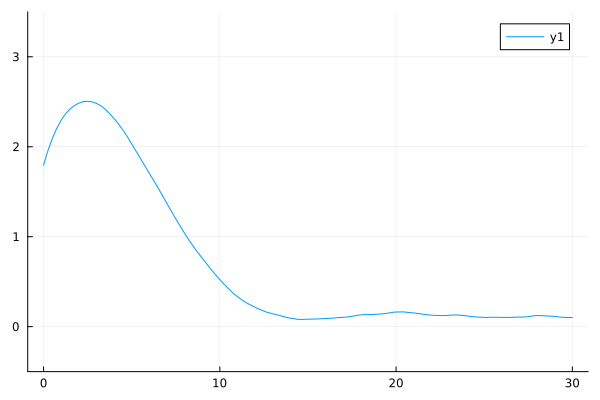

In [60]:
redMOTdata_3mW = deserialize("CaOH_redMOT_data//1.2mW.jl")
times = redMOTdata_3mW[8]
x_trajectories = redMOTdata_3mW[1]
mean_x_trajectory = mean(x_trajectories)
plot(times[1], mean_x_trajectory, ylim=(-0.5,3.5))

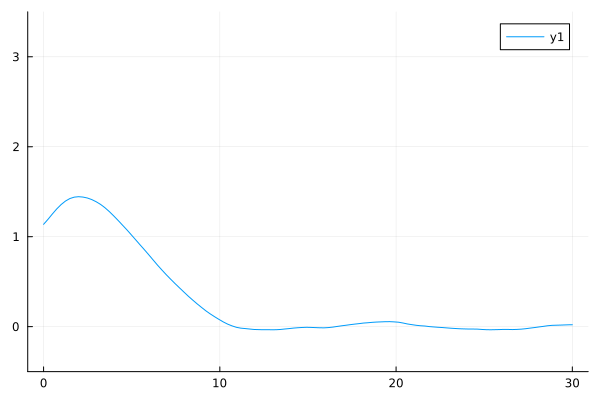

In [61]:
redMOTdata_3mW = deserialize("CaOH_redMOT_data//3mW.jl")
times = redMOTdata_3mW[8]
x_trajectories = redMOTdata_3mW[1]
mean_x_trajectory = mean(x_trajectories)
plot(times[1], mean_x_trajectory, ylim=(-0.5,3.5))

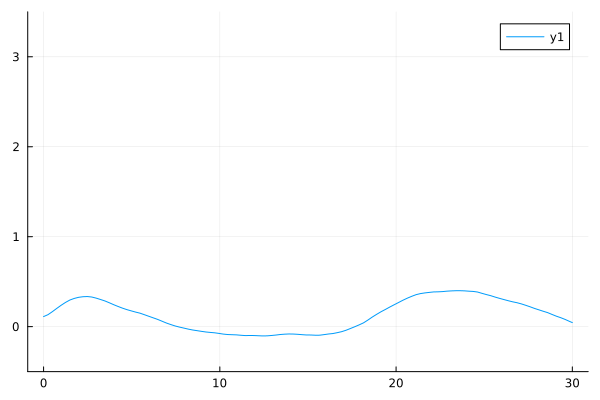

In [7]:
redMOTdata_3mW = deserialize("CaOH_redMOT_data//11.5mW.jl")
times = redMOTdata_3mW[8]
x_trajectories = redMOTdata_3mW[1]
mean_x_trajectory = mean(x_trajectories)
plot(times[1], mean_x_trajectory, ylim=(-0.5,3.5))

### CaF single frequency cooling

In [21]:
CaF_cooling_data = deserialize("CaF_singlefrequency_data//CaF_cooling_data.jl")
times = CaF_cooling_data.times
x_velocities = CaF_cooling_data.z_velocities
;

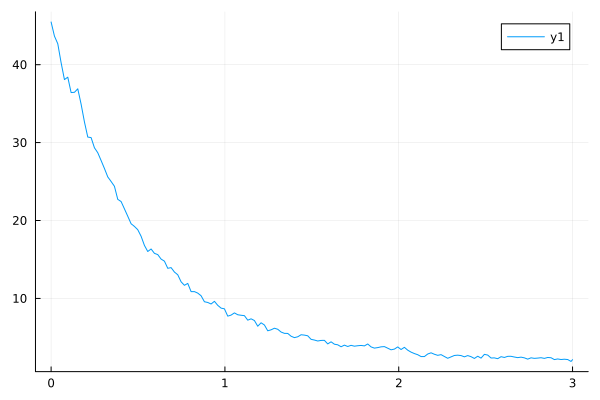

In [29]:
plot(legend=false, title="temperature", xlabel="time (ms)",ylabel="T (μK)")

vs_avg = Float64[]
for i ∈ eachindex(times[1])
    vs = Float64[]
    for j in 1:500
       v = x_velocities[j][i]
       push!(vs, v)
    end
    push!(vs_avg, std(vs)^2)
end

m = @with_unit 59 "u"
k_B = 1.381e-23
plot(times[1], 1e6 * vs_avg .* (m/k_B))

### CaF DC MOT (Tarbutt)

In [48]:
using LinearAlgebra, LsqFit

In [49]:
CaF_DCMOT_data = deserialize("CaF_DCMOT_Tarbutt//data.jl")
times = CaF_DCMOT_data.times
x_trajectories = CaF_DCMOT_data.x_trajectories
y_trajectories = CaF_DCMOT_data.y_trajectories
;

In [50]:
function project_xy(x_trajectory, y_trajectory)
    proj_traj = deepcopy(x_trajectory)
    xy_axis = (1,1,0) ./ sqrt(2)
    for i in eachindex(x_trajectory)
        x = x_trajectory[i]
        y = y_trajectory[i]
        xy = xy_axis ⋅ (x,y,0)
        proj_traj[i] = xy
    end
    proj_traj 
end
;

In [51]:
function survived(t_end, times, trajectories)
    _survived = Int64[]
    for i ∈ eachindex(times)
        if times[i][end] * 1e-3 ≈ t_end && abs(trajectories[i][end][1]) <= 10
            push!(_survived, i)
        end
    end
    return _survived
end
;

In [52]:
function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2)) 
end

function center(i, trajectories)
    
    xs = [trajectory[i] for trajectory ∈ trajectories]

    hist_data = fit(Histogram, xs, nbins=10)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    v_fit = curve_fit(Gaussian, v, fv, [0.6, 1.0, 2])
    σ, x0, A = v_fit.param

    return x0
end
;

In [53]:
function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2)) 
end;

In [54]:
survived_idxs = survived(14e-3, times, x_trajectories)
;

In [59]:
xy_trajectories = [project_xy(x_trajectories[i], y_trajectories[i]) for i ∈ survived_idxs]
plot(times[survived_idxs[1]], [center(i, xy_trajectories) for i ∈ eachindex(times[1])], ylim=(-2,4.2), xticks=0:2:14, legend=nothing, box=:on,
    xlabel="Time (ms)",
    ylabel="Displacement (mm)", size=(500,300), linewidth=3, framestyle=:box, dpi=300
)
savefig("CaF_DC_push.png")

"G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\plot_presentation_data\\CaF_DC_push.png"